Action2	
资金流入流出预测
https://tianchi.aliyun.com/competition/entrance/231573/information
数据集一共包括4张表：用户基本信息数据、用户申购赎回数据、收益率表和银行间拆借利率表
2.8万用户，284万行为数据，294天拆解利率，427天收益率
2013-07-01到2014-08-31，预测2014年9月的申购和赎回

1、说明解决方案思路（30points）
2、完成代码，使用时序或其他模型（40points）
3、提交结果Score > 120（30points）"	

说明解决方案思路:
1. 计算所有用户在测试集上每天的申购及赎回总额与实际情况总额的误差
2. 申购预测得分与 Purchasei 相关，赎回预测得分与 Redeemi 相关 , 误差与得分之间的计算公式不公布，但保证该计算公式为单调递减的，即误差越小，得分越高，误差与大，得分越低。当第 i 天的申购误差 Purchasei =0 ，这一天的得分为 10 分；当 Purchasei > 0.3 ，其得分为 0 
3. 最后公布总积分 = 申购预测得分 *45%+ 赎回预测得分 *55% 

# 数据探索

In [1]:
#数据加载,时间序列
import pandas
#parse_dates=['report_date']转换成日期类型
data = pandas.read_csv('./user_balance_table.csv', parse_dates=['report_date']) 
data

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840416,28033,2014-08-25,550646,550585,61,0,0,0,0,0,0,0,0,61,NaN,NaN,NaN,NaN
2840417,28033,2014-08-31,525707,538147,60,0,0,0,12500,12500,0,0,0,60,0.0,0.0,0.0,12500.0
2840418,28033,2014-07-24,20487121,20484824,2297,0,0,0,0,0,0,0,0,2297,NaN,NaN,NaN,NaN
2840419,28033,2014-07-27,20462288,20491722,2298,0,0,0,31732,0,31732,0,31732,2298,NaN,NaN,NaN,NaN


In [2]:
data.info()
#total_purchase_amt
#total_redeem_amt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2840421 entries, 0 to 2840420
Data columns (total 18 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              int64         
 1   report_date          datetime64[ns]
 2   tBalance             int64         
 3   yBalance             int64         
 4   total_purchase_amt   int64         
 5   direct_purchase_amt  int64         
 6   purchase_bal_amt     int64         
 7   purchase_bank_amt    int64         
 8   total_redeem_amt     int64         
 9   consume_amt          int64         
 10  transfer_amt         int64         
 11  tftobal_amt          int64         
 12  tftocard_amt         int64         
 13  share_amt            int64         
 14  category1            float64       
 15  category2            float64       
 16  category3            float64       
 17  category4            float64       
dtypes: datetime64[ns](1), float64(4), int64(13)
memory usage: 390.

In [3]:
#聚合
total_balance = data.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()
total_balance

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,total_purchase_amt,total_redeem_amt
report_date,,
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587
...,...,...
2014-08-27,302194801,468164147
2014-08-28,245082751,297893861
2014-08-29,267554713,273756380


In [4]:
purchase = total_balance[['total_purchase_amt']]
redeem = total_balance[['total_redeem_amt']]
redeem

,total_redeem_amt
report_date,
2013-07-01,5525022
2013-07-02,2554548
2013-07-03,5953867
2013-07-04,6410729
2013-07-05,2763587
...,...
2014-08-27,468164147
2014-08-28,297893861
2014-08-29,273756380


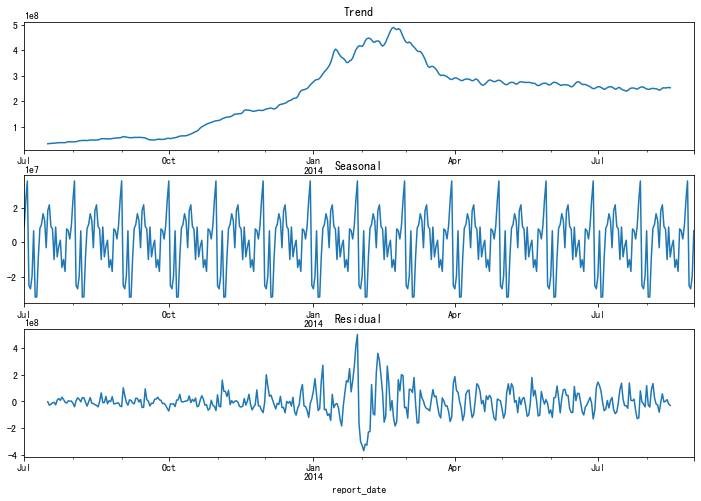

In [5]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
#制定区间范围内的数据进行可视化
def plot_stl(data):
    #STL返回三个部分:trend(趋势),seasonal(季节),residual(残差)
    result =  sm.tsa.seasonal_decompose(data,period=30)#以月为单位
    #可视化
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    
    result.trend.plot(ax=ax1,title = 'Trend')
    result.seasonal.plot(ax=ax2,title = 'Seasonal')
    result.resid.plot(ax=ax3,title = 'Residual')

plot_stl(purchase.total_purchase_amt)

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


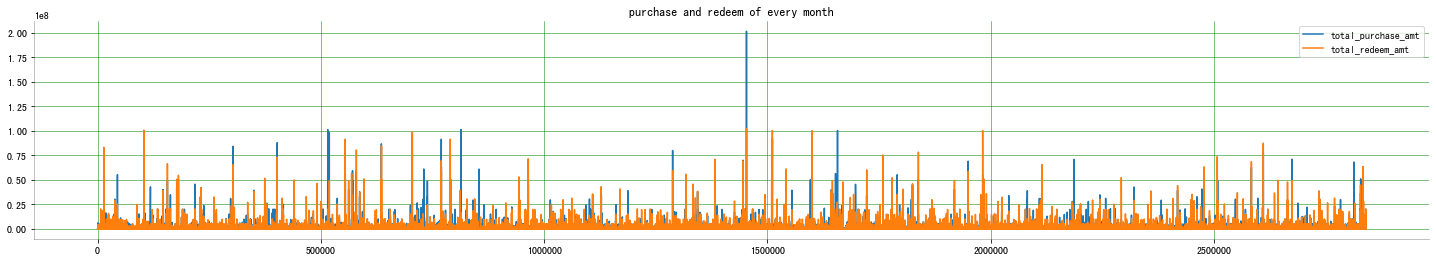

In [6]:
#可视化展示
plt.rcParams['figure.figsize'] = (25, 4.0)  # set figure size

data[['total_purchase_amt', 'total_redeem_amt']].plot()
plt.grid(True, linestyle="-", color="green", linewidth="0.5")
plt.legend()
plt.title('purchase and redeem of every month')

plt.gca().spines["top"].set_alpha(0.0)
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)
plt.gca().spines["left"].set_alpha(0.3)

plt.show()

In [7]:
purchase['ds'] = purchase.index
purchase.rename(columns={'total_purchase_amt':'y'},inplace=True)
purchase

,y,ds
report_date,,
2013-07-01,32488348,2013-07-01
2013-07-02,29037390,2013-07-02
2013-07-03,27270770,2013-07-03
2013-07-04,18321185,2013-07-04
2013-07-05,11648749,2013-07-05
...,...,...
2014-08-27,302194801,2014-08-27
2014-08-28,245082751,2014-08-28
2014-08-29,267554713,2014-08-29


In [8]:
redeem['ds'] = purchase.index
redeem.rename(columns={'total_redeem_amt':'y'},inplace=True)
redeem

,y,ds
report_date,,
2013-07-01,5525022,2013-07-01
2013-07-02,2554548,2013-07-02
2013-07-03,5953867,2013-07-03
2013-07-04,6410729,2013-07-04
2013-07-05,2763587,2013-07-05
...,...,...
2014-08-27,468164147,2014-08-27
2014-08-28,297893861,2014-08-28
2014-08-29,273756380,2014-08-29


In [9]:
purchase = purchase.reset_index(drop = True)
redeem = redeem.reset_index(drop = True)
redeem

,y,ds
0,5525022,2013-07-01
1,2554548,2013-07-02
2,5953867,2013-07-03
3,6410729,2013-07-04
4,2763587,2013-07-05
...,...,...
422,468164147,2014-08-27
423,297893861,2014-08-28
424,273756380,2014-08-29
425,196374134,2014-08-30


In [10]:
#
from fbprophet import Prophet
#拟合Prophet模型
model = Prophet(weekly_seasonality=True,seasonality_prior_scale=0.1,n_changepoints=300)
model.fit(purchase)
#预测未来一个月,9月份30天
future = model.make_future_dataframe(periods=30)
purchase_pred=model.predict(future)
print(purchase_pred)

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds         trend    yhat_lower    yhat_upper   trend_lower  \
0   2013-07-01  6.659731e+06 -6.418555e+07  1.715554e+08  6.659731e+06   
1   2013-07-02  7.449143e+06 -6.669390e+07  1.709715e+08  7.449143e+06   
2   2013-07-03  8.238556e+06 -6.523412e+07  1.637333e+08  8.238556e+06   
3   2013-07-04  9.027968e+06 -8.060263e+07  1.349792e+08  9.027968e+06   
4   2013-07-05  9.817381e+06 -1.328457e+08  1.067172e+08  9.817381e+06   
..         ...           ...           ...           ...           ...   
452 2014-09-26  1.996987e+08  6.819551e+07  3.004774e+08  1.978499e+08   
453 2014-09-27  1.989459e+08  8.878610e+06  2.439587e+08  1.969882e+08   
454 2014-09-28  1.981931e+08  1.278069e+07  2.515836e+08  1.961556e+08   
455 2014-09-29  1.974403e+08  1.285264e+08  3.499466e+08  1.953317e+08   
456 2014-09-30  1.966876e+08  1.284497e+08  3.603005e+08  1.944713e+08   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    6.659731e+06    4.477745e

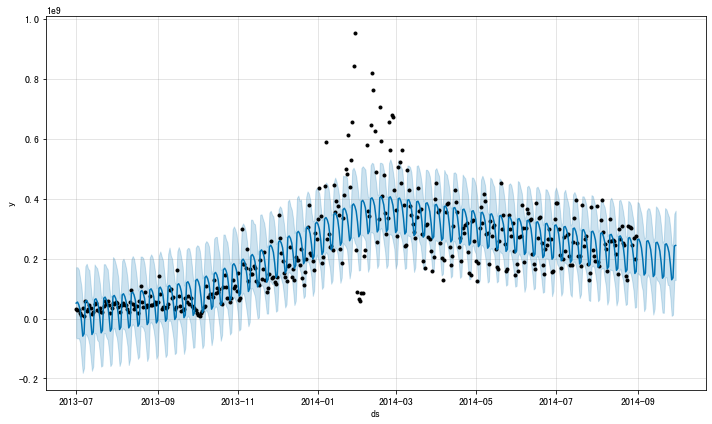

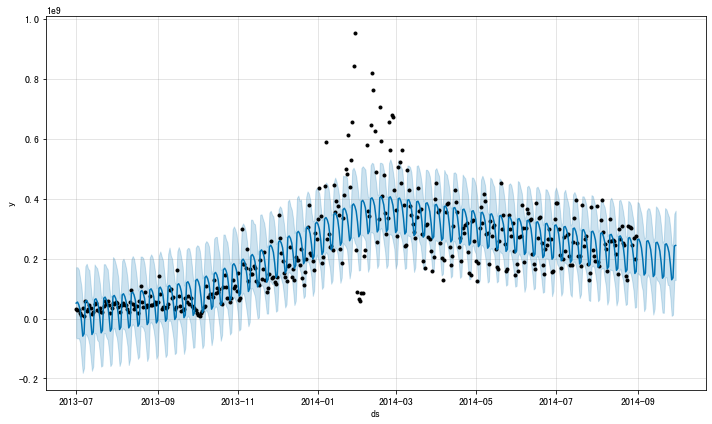

In [11]:
model.plot(purchase_pred)

In [12]:
#拟合Prophet模型redeem
model2 = Prophet(weekly_seasonality=True,seasonality_prior_scale=0.1,n_changepoints=300)
model2.fit(redeem)
#预测未来一个月,9月份30天
future = model2.make_future_dataframe(periods=30)
redeem_pred=model2.predict(future)
print(redeem_pred)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds         trend    yhat_lower    yhat_upper   trend_lower  \
0   2013-07-01 -1.556521e+07 -4.802843e+07  1.137955e+08 -1.556521e+07   
1   2013-07-02 -1.482612e+07 -8.251913e+07  8.696868e+07 -1.482612e+07   
2   2013-07-03 -1.408704e+07 -7.255345e+07  9.946058e+07 -1.408704e+07   
3   2013-07-04 -1.334795e+07 -9.393216e+07  7.912601e+07 -1.334795e+07   
4   2013-07-05 -1.260886e+07 -1.018219e+08  7.232598e+07 -1.260886e+07   
..         ...           ...           ...           ...           ...   
452 2014-09-26  2.903652e+08  1.964917e+08  3.736498e+08  2.897288e+08   
453 2014-09-27  2.905247e+08  1.488607e+08  3.196417e+08  2.898528e+08   
454 2014-09-28  2.906842e+08  1.682171e+08  3.321770e+08  2.899759e+08   
455 2014-09-29  2.908437e+08  2.616204e+08  4.289405e+08  2.900910e+08   
456 2014-09-30  2.910032e+08  2.246198e+08  3.978171e+08  2.902198e+08   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   -1.556521e+07    4.895767e

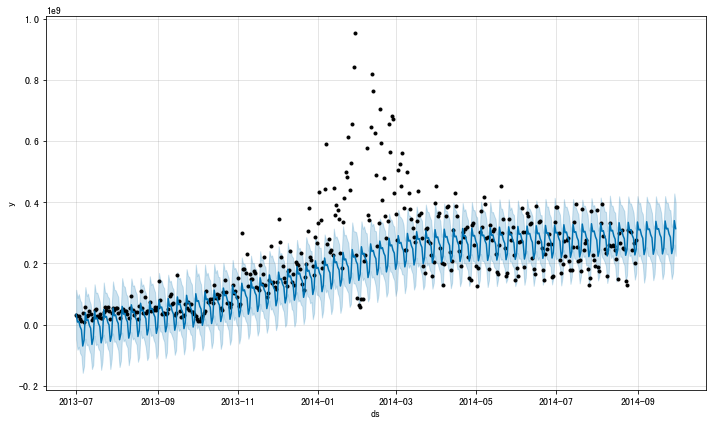

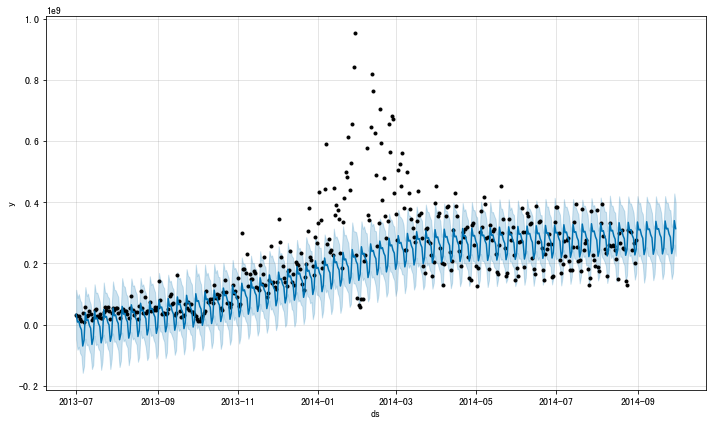

In [13]:
model.plot(redeem_pred)

In [14]:
purchase2 = purchase_pred[(purchase_pred['ds']>='2014-09-01') &(purchase_pred['ds']<='2014-09-30')][['ds','yhat']]
purchase2

,ds,yhat
427,2014-09-01,2.632957e+08
428,2014-09-02,2.653011e+08
429,2014-09-03,2.546673e+08
430,2014-09-04,2.357553e+08
431,2014-09-05,1.976467e+08
432,2014-09-06,1.452998e+08
433,2014-09-07,1.518536e+08
434,2014-09-08,2.580262e+08
435,2014-09-09,2.600316e+08
436,2014-09-10,2.493978e+08


In [15]:
redeam2 = redeem_pred[(redeem_pred['ds']>='2014-09-01') &(redeem_pred['ds']<='2014-09-30')][['ds','yhat']]
redeam2

,ds,yhat
427,2014-09-01,3.353353e+08
428,2014-09-02,3.092673e+08
429,2014-09-03,3.115720e+08
430,2014-09-04,2.929777e+08
431,2014-09-05,2.825034e+08
432,2014-09-06,2.287263e+08
433,2014-09-07,2.476110e+08
434,2014-09-08,3.364518e+08
435,2014-09-09,3.103838e+08
436,2014-09-10,3.126885e+08


In [16]:
import pandas as pd
#合并结果
result = pd.DataFrame()
result['ds'] = purchase2.ds
result['purchase_amt'] = purchase2.yhat
result['redeam_amt'] = redeam2.yhat
result

,ds,purchase_amt,redeam_amt
427,2014-09-01,2.632957e+08,3.353353e+08
428,2014-09-02,2.653011e+08,3.092673e+08
429,2014-09-03,2.546673e+08,3.115720e+08
430,2014-09-04,2.357553e+08,2.929777e+08
431,2014-09-05,1.976467e+08,2.825034e+08
432,2014-09-06,1.452998e+08,2.287263e+08
433,2014-09-07,1.518536e+08,2.476110e+08
434,2014-09-08,2.580262e+08,3.364518e+08
435,2014-09-09,2.600316e+08,3.103838e+08
436,2014-09-10,2.493978e+08,3.126885e+08


In [17]:
result['ds'] = result['ds'].apply(lambda x:str(x).replace('-','')[0:8])#日期格式去掉-

In [18]:
result.to_csv('prohet.csv',header=None,index=False)#提交查看成绩finalScore:77.0720

In [19]:
data = pandas.read_csv('./prohet.csv') 
data

,20140901,263295719.6785679,335335316.5955846
0,20140902,2.653011e+08,3.092673e+08
1,20140903,2.546673e+08,3.115720e+08
2,20140904,2.357553e+08,2.929777e+08
3,20140905,1.976467e+08,2.825034e+08
4,20140906,1.452998e+08,2.287263e+08
5,20140907,1.518536e+08,2.476110e+08
6,20140908,2.580262e+08,3.364518e+08
7,20140909,2.600316e+08,3.103838e+08
8,20140910,2.493978e+08,3.126885e+08
9,20140911,2.304858e+08,2.940942e+08
